### Deep Learning Homework 4

1. Now that you have all the tools to train an MLP with high performance on MNIST, try reaching 0-loss (or 100% accuracy) on the training data (with a small epsilon, e.g. 99.99% training performance -- don't worry if you overfit!). The implementation is completely up to you. You just need to keep it an MLP without using fancy layers (e.g., keep the Linear layers, don't use Conv1d or something like this, don't use attention). You are free to use any LR scheduler or optimizer, any one of batchnorm/groupnorm, regularization methods... If you use something we haven't seen during lectures, please motivate your choice and explain (as briefly as possible) how it works.
2. Try reaching 0-loss on the training data with permuted labels. Assess the model on the test data (without permuted labels) and comment. Tip: To permute the labels, act on the trainset.targets with an appropriate torch function. Then, you can pass this "permuted" Dataset to a DataLoader like so: trainloader_permuted = torch.utils.data.DataLoader(trainset_permuted, batch_size=batch_size_train, shuffle=True). You can now use this DataLoader inside the training function. Additional view for motivating this exercise: 

In [1]:
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
import pylab as pl
from IPython.display import clear_output
import seaborn as sns
sns.set_theme()
import time


# Training and other functions
from scripts import *

In [20]:
# 1. Achieve 99.99% train set accuracy

# Define the model
class MLP(nn.Module):
    """
    Implements a neural network to train on MNIST 
    """
    def __init__(self):
        super().__init__()
        self.layers = torch.nn.Sequential(
            torch.nn.Flatten(),
            torch.nn.Linear(784, 384),
            torch.nn.ReLU(),
            torch.nn.BatchNorm1d(384),
            torch.nn.Linear(384, 384),
            torch.nn.ReLU(),
            torch.nn.BatchNorm1d(384),
            torch.nn.Linear(384, 384),
            torch.nn.ReLU(),
            torch.nn.BatchNorm1d(384),
            torch.nn.Linear(384, 10),
            torch.nn.LogSoftmax(dim=1)
        )
        
    def forward(self, X):        
        return self.layers(X)

In [17]:
# Load the data
import torchvision
from torchvision.transforms import Compose, ToTensor, Normalize

# Change root_dir to the directory where to find MNIST
root_dir = '../data/'
transforms = Compose([
    ToTensor(),
    Normalize((0.1307,), (0.3081,))
    ])

# Training and test sets
train_set = torchvision.datasets.MNIST(root=root_dir, train=True, transform=transforms)
test_set = torchvision.datasets.MNIST(root=root_dir, train=False, transform=transforms)

# Create train and test loaders
batch_train, batch_test = 256, 512
train_loader = DataLoader(train_set, batch_size=batch_train, shuffle=True, num_workers=2)
test_loader = DataLoader(test_set, batch_size=batch_test, shuffle=False, num_workers=2)

In [18]:
def train_model(model, train_set, criterion, optimizer, n_epochs, 
                val_set=None, val_criterion=None, scheduler=None):    
    """
    Trains a model, can keep track of learning metrics on validation set
    and implements early stopping
    
    Parameters
    ----------
    model: nn.Module
        Model to train
    
    train_set: DataLoader
        Training set
        
    criterion: loss function
        Loss function criterion
    
    optimizer: torch optimizer
        Optimizer to use to train the model
    
    n_epochs: int
        Number of epochs to train the model
    
    val_set: DataLoader
        Validation set to keep track of the generalization error, Default: None
    
    val_criterion: loss function with signature f(model, val_set) -> float
        Evaluation criterion on the test set, Default: Same as criterion
        
    scheduler: torch.optim.lr_scheduler
        Learning rate scheduler, default: None
        
    Returns
    -------
    float: 
        Loss on the training epoch
    """
    train_losses = []
    train_accuracies = []
    val_accuracies = []
        
    for epoch in range(n_epochs):
        clear_output(wait=True)
        
        t0 = time.time()
        # Model training
        train_loss = train_epoch(model, train_set, criterion, optimizer)
        train_losses.append(train_loss)
        
        # Train accuracy
        train_accuracy = 1-eval_model(model, train_set, val_criterion)
        train_accuracies.append(train_accuracy)
        
        # Test accuracy
        val_accuracy = 1-eval_model(model, val_set, val_criterion)
        val_accuracies.append(val_accuracy)
        
        # Step the scheduler
        scheduler.step(train_accuracy)
        
        # Print progress
        print(f"""Epoch: {epoch}, time: {time.time() - t0} [s]
        Train loss: {train_loss}
        Train accuracy: {train_accuracy}
        Validation accuracy: {val_accuracy}""")
        pl.clf()
        pl.plot(train_accuracies)
        pl.plot(val_accuracies)
        pl.show()
            
        # Stop training
        if(train_accuracy > 1 - 1e-4):
            print("Reached early stopping!")
            break
        
    return train_losses, train_accuracies, val_accuracies
    

Epoch: 6, time: 17.15180778503418 [s]
        Train loss: 0.004998154570410649
        Train accuracy: 0.9999666666666667
        Validation accuracy: 0.9834999999850988


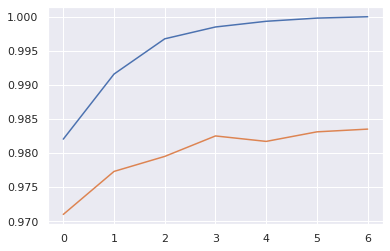

Reached early stopping!


In [21]:
# Train with Cross entropy and SGD
net = MLP()
loss = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(net.parameters(), lr=0.01, momentum=0.9)
# I added a scheduler to help the optimizer to reach maximum accuracy on train data
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', patience=2)
_, train_accuracies, val_accuracies = train_model(net, train_loader, loss, optimizer, n_epochs=30, 
                                                  val_set=test_loader, val_criterion=accuracy, scheduler=scheduler)

In [23]:
train_accuracies[-1], val_accuracies[-1]

(0.9999666666666667, 0.9834999999850988)

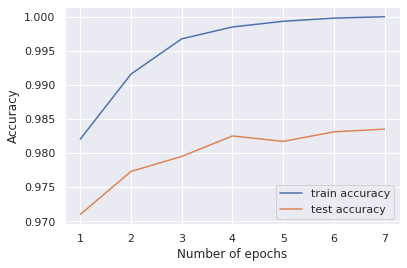

In [24]:
epochs = list(range(1, len(train_accuracies)+1))
pl.plot(epochs, train_accuracies, label="train accuracy")
pl.plot(epochs, val_accuracies, label="test accuracy")
pl.ylabel("Accuracy")
pl.xlabel("Number of epochs")
pl.legend()
pl.show()

We see that after epoch 6 the train accuracy reaches values very close to 1 and by epoch 11 it reached 1, this is expected since our model has over 600k parameters and the training set is composed of 50k examples.  
Another very interesting result is that the test accuracy follows very closely the behaviour of the training accuracy, even when the model is obviously overfitting the generalization error still decreases, this means that the net manages to find useful structure in the data even in overfitting regime.  

In [5]:
# 2. Achieve 99.99% train set accuracy on a training set with permuted labels

# Create a training set with permuted labels
from copy import deepcopy

def shuffle(x):
    return x[torch.randperm(x.size()[0])]

train_set_permuted = deepcopy(train_set)
train_set_permuted.targets = shuffle(train_set_permuted.targets)

train_loader_permuted = DataLoader(train_set_permuted, batch_size=batch_train,
                                   shuffle=True, num_workers=2)

Epoch: 115, time: 20.80112385749817 [s]
        Train loss: 0.02388506369193395
        Train accuracy: 0.9999666666666667
        Validation accuracy: 0.10330000057220456


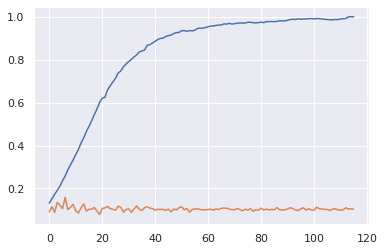

Reached early stopping!


In [6]:
# Train with Cross entropy and SGD
net = MLP()
loss = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(net.parameters(), lr=0.01, momentum=0.9)
# I added a scheduler to help the optimizer to reach maximum accuracy on train data
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', patience=10)
_, train_accuracies, val_accuracies = train_model(net, train_loader_permuted, loss, optimizer, n_epochs=300, 
                                                  val_set=test_loader, val_criterion=accuracy, scheduler=scheduler)

In [10]:
train_accuracies[-1], val_accuracies[-1]

(0.9999666666666667, 0.10330000057220456)

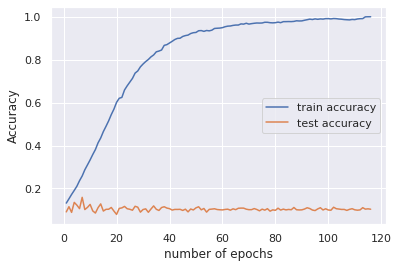

In [9]:
epochs = list(range(1,len(train_accuracies)+1))
pl.plot(epochs, train_accuracies, label="train accuracy")
pl.plot(epochs, val_accuracies, label="test accuracy")
pl.ylabel("Accuracy")
pl.xlabel("number of epochs")
pl.legend()
pl.show()

After a much higher number of epochs(115 vs 7) we managed to reach 99.997% accuracy, from a mathematical point of view this is expected since we have much more free variables than number of equations, however from a practical viewpoint the net shouldn't be able to learn because there isn't actually anything to learn <sup>[[1]](https://arxiv.org/abs/1611.03530 "Understanding deep learning requires rethinking generalization")</sup>  
The net in this case is like the student that memorizes everything instead of grasping the underlying concepts

Finally notice that we used a very big and over-parametrized network, we tried to fit a random labelling with smaller networks but the classifier doesn't reach 99.99% accuracy, we think this is because with over-parametrization we are enlarging the dimension of the space with loss=0, so we are in a certain sense adding global minimas and learning can progress without stumbling in a local minima. Another advantage of a bigger network is that we reduced training time in the true labels case, this seems unintuitive because a bigger network requires more computational time to evaluate, however on our computer we see that with the same network architecture as the one we used but with only 128 units in each layer we take 13s per epoch and need 14 epochs to reach 99.99% accuracy, while the bigger network that we used takes 17s per epoch but only needs 7 epochs, that is a 1.5x speedup.